In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from config import params, base_url
%matplotlib notebook

https://maps.googleapis.com/maps/api/geocode/json


In [ ]:
# Dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from config import params, base_url

def wine_dropna(wine_data, col): 
    wine_data.dropna(subset=[col], inplace = True)
    print("wine_data size, after dropping NaN for "+ col + ": " + str(wine_data.shape))

def get_country_data(data, country): 
    ret_df = data.loc[data['country'] == country].copy()
    if ret_df.shape[0] > 0: 
        print('Record count for Country, ' + str(country) + ': ' + str(ret_df.shape))
        return ret_df
    else: 
        return None

def get_g_address(winery_geo): 

    formatted_address = winery_geo["results"][0]['formatted_address']
    formed_address_list = winery_geo["results"][0]['address_components']
    try: 
        street_number = formed_address_list[0]['long_name']
        route = formed_address_list[1]['long_name']
        locality = formed_address_list[2]['long_name']
        administrative_area_level_2 = formed_address_list[3]['long_name']
        administrative_area_level_1 = formed_address_list[4]['long_name']
        g_country = formed_address_list[5]['long_name']
        postal_code = formed_address_list[6]['long_name']
    except: 
        return None
    
    ret_data = (formatted_address, formed_address_list, 
                street_number, route, locality, 
                administrative_area_level_2, 
                administrative_area_level_1, 
                g_country, 
                postal_code)
    return ret_data

def check_match(formed_address, province, country): 
    return country != formed_address[7] or province != formed_address[5]

def write_results(out_path, content): 
    out_dir_name = os.path.dirname(out_path)

    if not os.path.exists(out_dir_name): 
        os.mkdir(out_dir_name, 511)
    file_name = os.path.split(out_path)[1]
    
    with open(os.path.join(out_dir_name, file_name), 'a') as ctx: 
        ctx.write(content)

wine_data = pd.read_csv('Data/winemag-data-130k-v2.csv')
wine_data.head()

cleaned_wine_data_ind_cntrs = wine_data.copy()
cleaned_wine_data_all_cntrs = wine_data.copy()

non_nullable_colums_for_individual_countries = [
                       'title', 
                       'price', 
                       'points',
                       'winery',  
                       'taster_name', 
                       'region_1'
                      ]

non_nullable_colums_for_all_countries = [
                       'title', 
                       'price', 
                       'points',
                       'winery',  
                       'taster_name'
                      ]

countries = list(cleaned_wine_data_ind_cntrs.country.unique())

print(countries)
print(len(countries))

for cols in non_nullable_colums_for_individual_countries: 
    wine_dropna(cleaned_wine_data_ind_cntrs, cols)
    
for cols in non_nullable_colums_for_all_countries: 
    wine_dropna(cleaned_wine_data_all_cntrs, cols)

data_columns_for_study = ['title', 'description', # Wine
                          'taster_name', 'taster_twitter_handle', 'points', 'price', # Rating
                          'variety', 'winery', # Wine Type
                          'province', 'region_1', 'country' # Area
                         ]
cleaned_wine_data_ind_cntrs = cleaned_wine_data_ind_cntrs[data_columns_for_study]
cleaned_wine_data_all_cntrs = cleaned_wine_data_all_cntrs[data_columns_for_study]

country_data = pd.DataFrame()
print(base_url)
unfound_winery = [{}]
for country in countries: 
    country_data = get_country_data(cleaned_wine_data_ind_cntrs, country)
    
    if isinstance(country_data, pd.DataFrame):
        if (country == 'Australia'): 
            print(country)
            country_data['latitude'] = ''
            country_data['longitude'] = ''
            country_data['g_address'] = ''
            country_data.index = pd.RangeIndex(len(country_data.index))
            address_dict = {}
            for index, row in country_data.iterrows(): 
                print(index)
                winery_address = f"{row['winery']} winery, {row['region_1']}, {row['province']}, {row['country']}"
                if not winery_address in address_dict.keys(): 
                    address_dict.update({winery_address: []})
                    params['address'] = winery_address
                    response = requests.get(base_url, params=params)
                    # print(response)
                    if response.status_code == 200:
                    # Extracting data in json format
                        winery_geo = response.json()
                        if winery_geo.get("results", []):
                            lat = winery_geo["results"][0]["geometry"]["location"]["lat"]
                            lon = winery_geo["results"][0]["geometry"]["location"]["lng"]
                        else: 
                            unfound_winery.append({'winery_address': f"{row['winery']} winery, {row['region_1']}, {row['province']}, {row['country']}"})
                            country_data.drop([index])
                            address_dict.pop(winery_address)
                            continue
                    formed_address = get_g_address(winery_geo)
                    if formed_address == None: 
                        unfound_winery.append({'winery_address': f"{row['winery']} winery, {row['region_1']}, {row['province']}, {row['country']}"})
                        country_data.drop([index])
                        address_dict.pop(winery_address)
                        continue
                    check_match_count = 0
                    is_winery_add_found = True
                    while not check_match(formed_address, row['province'], country): 
                        check_match_count += 1
                        params['address'] = f"{row['region_1']}, {row['province']}, {row['country']}"
                        response = requests.get(base_url, params=params)
                        winery_geo = response.json()
                        formed_address = get_g_address(winery_geo)
                        if check_match_count > 1: 
                            unfound_winery.append({'winery_address': f"{row['winery']} winery, {row['region_1']}, {row['province']}, {row['country']}"})
                            country_data.drop([index])
                            is_winery_add_found = False
                            address_dict.pop(winery_address)
                            break
                    if not is_winery_add_found: 
                        continue

                    formed_address = f'{formed_address[2]}~~~~{formed_address[3]}~~~~{formed_address[4]}~~~~{formed_address[5]}~~~~{formed_address[6]}~~~~{formed_address[7]}~~~~{formed_address[8]}'
                    
                    address_dict[winery_address] = [lat, lon, formed_address]
                    country_data.at[index, 'latitude'] = str(lat)
                    country_data.at[index, 'longitude'] = str(lon)
                    country_data.at[index, 'g_address'] = str(formed_address)
                    # print(f"Winery: {winery_address} ; LAT: {lat} ; LON: {lon}; Address: {formed_address}")
                else: 
                    lat = address_dict[winery_address][0]
                    lon = address_dict[winery_address][1]
                    formed_address = address_dict[winery_address][2]
                    country_data.at[index, 'latitude'] = str(lat)
                    country_data.at[index, 'longitude'] = str(lon)
                    country_data.at[index, 'g_address'] = str(formed_address)
            print(country_data.shape)
            country_data['g_address'].replace('', np.nan, inplace=True)
            wine_dropna(country_data, 'g_address')
            print(country_data.shape)
            country_data.to_excel('output.xlsx', sheet_name=country, float_format="%.12f")
    else: 
        continue
    
# print('--------------------------------------')
# for country in countries: 
#     country_data = get_country_data(cleaned_wine_data_all_cntrs, country)

print(unfound_winery)

In [2]:
countries = ['Australia', 'Canada', 'France', 'Italy', 'Spain', 'US']
comparison_data = {}
bar_data = {}
x_axis = np.arange(len(countries))
colors = ['r', 'g', 'b', 'y', 'm', 'c']
bar_width = 0.25
alp = 0.3
x_axis

array([0, 1, 2, 3, 4, 5])

In [3]:

for index, country in enumerate(countries): 
    datatrame_list = []
    file_name = 'output_' + country + '.xlsx'
    c_data = pd.read_excel(file_name)
    
    c_data = c_data.rename(index= str, columns={'title':'Title', 'description': 'Description',
                                                'taster_name': 'Sommelier', 'taster_twitter_handle':'Sommelier Twitter Acc.',
                                                'points': 'Points', 'price':"Price", 'variety': 'Variety', 'winery': 'Winery',
                                                'province':'State', 'region_1': 'County', 'latitude': 'Lat', 'longitude': "Lng",
                                                'g_address': 'Address'})
    
    winery_max_price = c_data.groupby(['Variety'])['Price'].max().to_frame()

    winery_max_points = c_data.groupby(['Variety'])['Points'].max().to_frame()
    
    winery_competitive_score = winery_max_price.merge(winery_max_points, how = 'inner', on = 'Variety')
    
    winery_competitive_score['Ratio'] = winery_competitive_score['Points'] / winery_competitive_score['Price']
    
    winery_competitive_score = winery_competitive_score.sort_values(by = 'Ratio', ascending = False)
    
    datatrame_list.append(winery_competitive_score)
    
    
    ratio_data = winery_competitive_score.reset_index()['Ratio'].tolist()
    ratio_data = [round(float(x), 2) for x in ratio_data[0:3]]
    print(f'{country}: {ratio_data}')
    bar_data[country] = ratio_data
    
    
    median_price_by_winery_variety_df = c_data.groupby(['Winery', 'Variety'])['Price'].median().to_frame()
    
    median_price_by_winery_variety_df = median_price_by_winery_variety_df.sort_values(by=["Price"], ascending = False)
    
    
    datatrame_list.append(median_price_by_winery_variety_df)
    
    comparison_data.update({country: datatrame_list})
    


Australia: [6.77, 5.93, 5.87]
Canada: [6.92, 5.06, 4.74]
France: [9.44, 8.6, 7.73]
Italy: [7.33, 6.29, 6.14]
Spain: [12.14, 10.62, 8.4]
US: [8.6, 7.33, 6.77]


In [ ]:
# for k, v_list in comparison_data.items(): 
#     print(k)
#     print('------------------')
#     print(v_list[0].head())

# country_df = {
#     "usa" : [df1]
# }
        
# print(len(comparison_data))
for df in comparison_data:
#     print(len(comparison_data[df]))
    print(df)
    print("------------------------------------")
    for index in range(len(comparison_data[df])):
        print(comparison_data[df][index])
        print("------------------------------------")

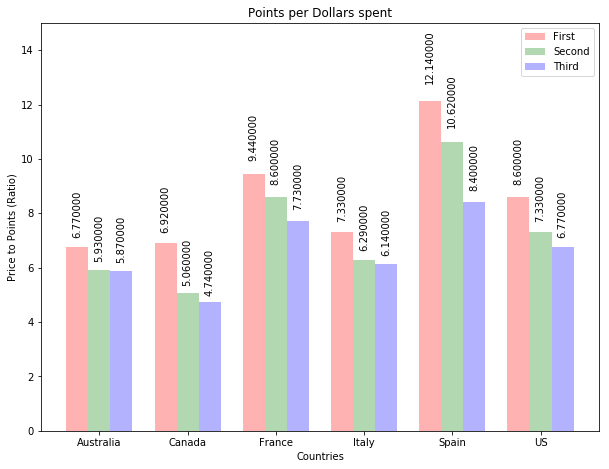

In [4]:

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%f'%h,
                ha='center', va='bottom', rotation = 'vertical')
#contry length
x_axis = np.arange(len(countries))
legend_labels = ['First', 'Second', 'Third', 'Fourth', 'Fifth', 'Sixth']

#rotate y axis
y_axis_t = []
for index, country in enumerate(bar_data): 
    y_axis_t.append(bar_data[country])
y_axis_t = tuple(y_axis_t)
y_axis_arr = np.column_stack(y_axis_t)#2 dimension array

#figure size
fig, ax = plt.subplots(figsize=(10,7.5))

#plot Graph 
box = []

for ind in range(3):
    box.append(ax.bar(x_axis + (bar_width * (ind + 7)),
                       y_axis_arr[ind], bar_width, 
                       color=colors[ind], alpha = alp))


ax.set_xlabel('Countries')
ax.set_ylabel('Price to Points (Ratio)')
ax.set_title('Points per Dollars spent')
ax.set_xticks(x_axis + bar_width * 8)
ax.set_xticklabels(('Australia', 'Canada', 'France', 'Italy', 'Spain', 'US'))
ax.set_ylim(0,15)
ax.legend((box[0][0], box[1][0], box[2][0]), legend_labels)

for ind in range(3):
    autolabel(box[ind])
plt.savefig("Points per Dollars spent.png")

In [5]:
pricing_by_winery_data = {}
for country in countries: 
    file_name = 'output_' + country + '.xlsx'
    datatrame_list = []
    c_data = pd.read_excel(file_name)
    
    c_data = c_data.rename(index= str, columns={'title':'Title', 'description': 'Description',
                                                'taster_name': 'Sommelier', 'taster_twitter_handle':'Sommelier Twitter Acc.',
                                                'points': 'Points', 'price':"Price", 'variety': 'Variety', 'winery': 'Winery',
                                                'province':'State', 'region_1': 'County', 'latitude': 'Lat', 'longitude': "Lng",
                                                'g_address': 'Address'})
    median_price_by_winery_df = c_data.groupby(['Winery'])['Price'].median().to_frame()
    median_price_by_winery_df = median_price_by_winery_df.sort_values(by=["Price"], ascending = False)
    pricing_by_winery_data.update({country: datatrame_list})
    
    print(median_price_by_winery_df.head(10))
    
    price_by_winery = median_price_by_winery_df.reset_index()['Price'].tolist()
    price_by_winery = [round(float(x), 2) for x in price_by_winery[0:3]]
    print(f'{country}: {price_by_winery}')
    bar_data[country] = price_by_winery
    

                  Price
Winery                 
Cloudburst        225.0
Standish          135.0
Giaconda          112.5
Andrew Hardy      105.0
Torbreck          105.0
Casella           100.0
Heathcote Estate   95.0
Yarra Yering       90.0
Jasper Hill        85.0
Apogee             80.0
Australia: [225.0, 135.0, 112.5]
                       Price
Winery                      
Wayne Gretzky Estates   95.0
Peller                  87.5
Inniskillin             80.0
Equifera                70.0
Stratus                 70.0
Reif Estate             50.0
Mission Hill            50.0
Le Vieux Pin            45.0
CedarCreek              45.0
Foxtrot                 44.0
Canada: [95.0, 87.5, 80.0]
                                Price
Winery                               
Château les Ormes Sorbet       3300.0
Domaine du Comte Liger-Belair  1562.5
Château Laville Haut-Brion      580.0
Château La Mission Haut-Brion   524.0
Domaine Leflaive                500.5
Château Cheval Blanc            500.0


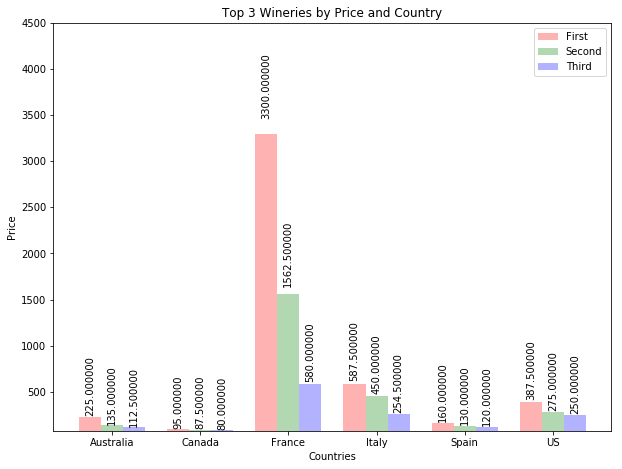

In [6]:
y_axis_t = []
for index, country in enumerate(bar_data): 
    y_axis_t.append(bar_data[country])
y_axis_t = tuple(y_axis_t)
y_axis_arr = np.column_stack(y_axis_t)

fig, ax = plt.subplots(figsize=(10,7.5))

box = []

for ind in range(3):
    box.append(ax.bar(x_axis + (bar_width * (ind + 7)),
                       y_axis_arr[ind], bar_width, 
                       color=colors[ind], alpha = alp))


ax.set_xlabel('Countries')
ax.set_ylabel('Price')
ax.set_title('Top 3 Wineries by Price and Country')
ax.set_xticks(x_axis + bar_width * 8)
ax.set_xticklabels(('Australia', 'Canada', 'France', 'Italy', 'Spain', 'US'))
ax.set_ylim(75, 4500)
ax.legend((box[0][0], box[1][0], box[2][0]), legend_labels)

for ind in range(3):
    autolabel(box[ind])
plt.savefig("Top 3 Wineries by Price and Country.png")

In [7]:
scoring_by_winery_data = {}
for country in countries: 
    file_name = 'output_' + country + '.xlsx'
    datatrame_list = []
    c_data = pd.read_excel(file_name)
    
    c_data = c_data.rename(index= str, columns={'title':'Title', 'description': 'Description',
                                                'taster_name': 'Sommelier', 'taster_twitter_handle':'Sommelier Twitter Acc.',
                                                'points': 'Points', 'price':"Price", 'variety': 'Variety', 'winery': 'Winery',
                                                'province':'State', 'region_1': 'County', 'latitude': 'Lat', 'longitude': "Lng",
                                                'g_address': 'Address'})
    median_points_by_winery_df = c_data.groupby(['Winery'])['Points'].median().to_frame()
    median_points_by_winery_df = median_points_by_winery_df.sort_values(by=["Points"], ascending = False)
    scoring_by_winery_data.update({country: datatrame_list})
    
    print(median_points_by_winery_df.head(10))
    
    points_by_winery = median_points_by_winery_df.reset_index()['Points'].tolist()
    points_by_winery = [round(float(x), 2) for x in points_by_winery[0:3]]
    print(f'{country}: {points_by_winery}')
    bar_data[country] = points_by_winery
    

                 Points
Winery                 
Standish           97.0
Tolpuddle          94.0
Hickinbotham       94.0
Giaconda           93.5
Eldridge Estate    93.0
John's Blend       93.0
Casella            93.0
Cherubino          93.0
Kay Brothers       93.0
Kalleske           92.0
Australia: [97.0, 94.0, 94.0]
                       Points
Winery                       
Le Vieux Pin             93.0
Vanessa                  92.5
Kettle Valley            92.0
Vista d'Oro              92.0
Tantalus                 92.0
Stratus                  92.0
Laughing Stock           92.0
LaStella                 92.0
Wayne Gretzky Estates    92.0
CedarCreek               92.0
Canada: [93.0, 92.5, 92.0]
                      Points
Winery                      
Clos de Tart            98.0
Salon                   97.5
Domaine Leflaive        97.0
J.L. Chave              97.0
Barons de Rothschild    96.0
Domaine Jean Grivot     96.0
Domaine des Lambrays    96.0
Château Cheval Blanc    96.0
Châte

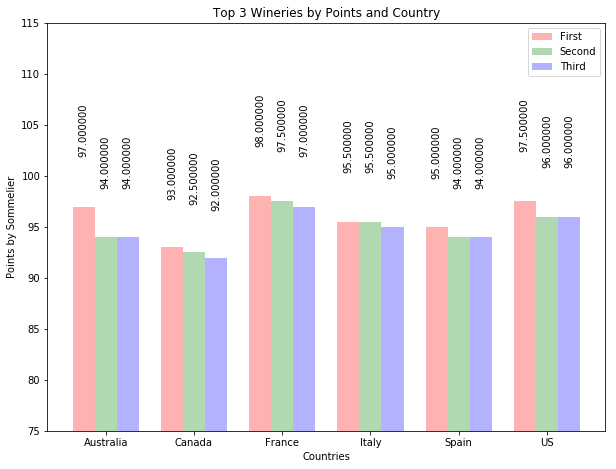

In [9]:

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%f'%h,
                ha='center', va='bottom', rotation = 'vertical')
        
y_axis_t = []
for index, country in enumerate(bar_data): 
    y_axis_t.append(bar_data[country])
y_axis_t = tuple(y_axis_t)
y_axis_arr = np.column_stack(y_axis_t)

fig, ax = plt.subplots(figsize=(10,7.5))

box = []

for ind in range(3):
    box.append(ax.bar(x_axis + (bar_width * (ind + 7)),
                       y_axis_arr[ind], bar_width, 
                       color=colors[ind], alpha = alp))


ax.set_xlabel('Countries')
ax.set_ylabel('Points by Sommelier')
ax.set_title('Top 3 Wineries by Points and Country')
ax.set_xticks(x_axis + bar_width * 8)
ax.set_xticklabels(('Australia', 'Canada', 'France', 'Italy', 'Spain', 'US'))
ax.set_ylim(75, 115)

ax.legend((box[0][0], box[1][0], box[2][0]), legend_labels)

for ind in range(3):
    autolabel(box[ind])
plt.savefig("Top 3 Wineries by Points and Country.png")

In [10]:
scoring_by_variety_data = {}
for country in countries: 
    file_name = 'output_' + country + '.xlsx'
    datatrame_list = []
    c_data = pd.read_excel(file_name)
    
    c_data = c_data.rename(index= str, columns={'title':'Title', 'description': 'Description',
                                                'taster_name': 'Sommelier', 'taster_twitter_handle':'Sommelier Twitter Acc.',
                                                'points': 'Points', 'price':"Price", 'variety': 'Variety', 'winery': 'Winery',
                                                'province':'State', 'region_1': 'County', 'latitude': 'Lat', 'longitude': "Lng",
                                                'g_address': 'Address'})
    median_points_by_variety_df = c_data.groupby(['Variety'])['Points'].median().to_frame()
    median_points_by_variety_df = median_points_by_variety_df.sort_values(by=["Variety"], ascending = False)
    scoring_by_variety_data.update({country: datatrame_list})
    
    print(median_points_by_variety_df.head(10))
    
    top_wineries_by_variety = median_points_by_variety_df.reset_index()['Variety'].tolist()
    top_wineries_by_variety = top_wineries_by_variety[0:10]
    
    points_by_variety = median_points_by_variety_df.reset_index()['Points'].tolist()
    points_by_variety = [round(float(x), 2) for x in points_by_variety[0:3]]
    print(f'{country}: {points_by_variety}')
    bar_data[country] = points_by_variety
    

                 Points
Variety                
Zinfandel          88.0
White Blend        87.5
Viognier           89.0
Vermentino         85.5
Verdelho           87.0
Tokay              90.0
Tempranillo        89.0
Sémillon           90.0
Syrah              92.0
Sparkling Blend    89.0
Australia: [88.0, 87.5, 89.0]
                         Points
Variety                        
White Blend                88.0
Viognier                   87.5
Vidal Blanc                89.5
Vidal                      91.0
Syrah                      90.5
Sauvignon Blanc            89.0
Rosé                       88.0
Riesling                   90.0
Rhône-style White Blend    90.0
Red Blend                  91.0
Canada: [88.0, 87.5, 89.5]
                       Points
Variety                      
White Blend              87.0
Viognier                 90.0
Vermentino               88.0
Trousseau                87.0
Tokay Pinot Gris         89.0
Tannat-Cabernet Franc    90.0
Tannat-Cabernet          89.5
T

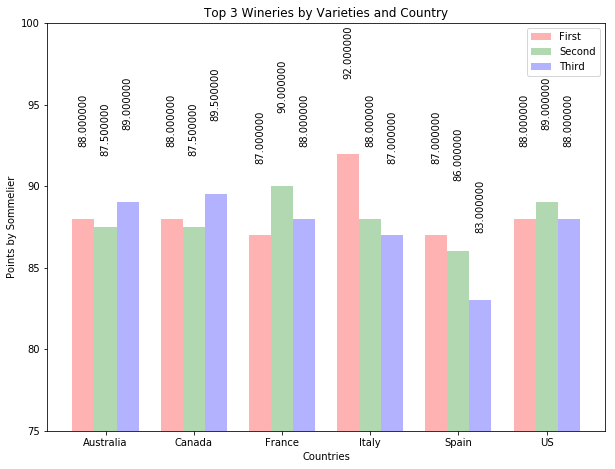

In [13]:
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%f'%h,
                ha='center', va='bottom', rotation = 'vertical')

y_axis_t = []
for index, country in enumerate(bar_data): 
    y_axis_t.append(bar_data[country])
y_axis_t = tuple(y_axis_t)
y_axis_arr = np.column_stack(y_axis_t)

fig, ax = plt.subplots(figsize=(10, 7.5))

box = []

for ind in range(3):
    box.append(ax.bar(x_axis + (bar_width * (ind + 7)),
                       y_axis_arr[ind], bar_width, 
                       color=colors[ind], alpha = alp))


ax.set_xlabel('Countries')
ax.set_ylabel('Points by Sommelier')
ax.set_title('Top 3 Wineries by Varieties and Country')
ax.set_xticks(x_axis + bar_width * 8)
ax.set_xticklabels(('Australia', 'Canada', 'France', 'Italy', 'Spain', 'US'))
ax.set_ylim(75, 100)

ax.legend((box[0][0], box[1][0], box[2][0]), legend_labels)

for ind in range(3):
    autolabel(box[ind])
plt.savefig("Top 3 Wineries by Varieties and Country.png")    

In [ ]:
points_by_sommelier_data = {}

file_name = 'output.xlsx'
datatrame_list = []
c_data = pd.read_excel(file_name)

c_data = c_data.rename(index= str, columns={'title':'Title', 'description': 'Description',
                                            'taster_name': 'Sommelier', 'taster_twitter_handle':'Sommelier Twitter Acc.',
                                            'points': 'Points', 'price':"Price", 'variety': 'Variety', 'winery': 'Winery',
                                            'province':'State', 'region_1': 'County', 'latitude': 'Lat', 'longitude': "Lng",
                                            'g_address': 'Address'})
max_points_by_sommelier_df = c_data.groupby(['Sommelier'])['Points'].max().to_frame()
max_points_by_sommelier_df = max_points_by_sommelier_df.sort_values(by=["Points"], ascending = False)
max_points_by_sommelier_df.update({country: datatrame_list})

# max_points_by_sommelier = max_points_by_sommelier_df.reset_index()['Points'].tolist()
# max_points_by_sommelier = [round(float(x), 2) for x in max_points_by_sommelier[0:10]]
# print(f'{country}: {max_points_by_sommelier}')
# bar_data[country] = max_points_by_sommelier